<font size="6"><b>EDA</b></font>  
The objective of this notebook is to perform exploratory data analysis on the data. This analysis is fundamental in order to  understand the composition of the dataset and perform the necessary pre-processing.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import re 
from sklearn.feature_extraction.text import CountVectorizer
from langdetect import detect

In [2]:
df=pd.read_csv('Final Tweets.csv')

# Checking for null values 
print(df.isnull().sum()) 
df=df.dropna()

print(df.shape[0])

Serial       0
Tweets       0
Sentiment    1
dtype: int64
25234


By sampling randomly from the data we observed that a subset of the tweets were in French. As the dataset was not manually curated by us and was obtained through web scraping, the presence of outliers is a possibility. Therefore, a crucial step in the analysis process is to eliminate the tweets in languages other than English.

In [3]:
def identify_non_en_tweets(df):
    serials = []
    
    for index, row in df.iterrows():
        try:
            if detect(row['Tweets']) != 'en':  # Check if tweet is not in English
                serials.append(row['Serial'])
        except Exception as e:
            print(f"Error detecting language for serial {row['Serial']}: {e}")
    
    return serials

non_english_serials = identify_non_en_tweets(df)
print('Number of non-English tweets that will be removed:', len(non_english_serials))

df = df[~df['Serial'].isin(non_english_serials)]
print('Remaining rows after removal:', df.shape[0])

Error detecting language for serial 9258: No features in text.
Number of non-English tweets that will be removed: 2397
Remaining rows after removal: 22837


The previous process discarded a non-irrelevant number of tweets (2397). The next part of the analysis is specific to Twitter data and involves removing non-ASCII characters, urls, usernames, etc.

In [7]:
# Get all non-ASCII characters
non_ascii_chars = set(''.join(df['Tweets'].dropna()))
non_ascii_chars = {c for c in non_ascii_chars if ord(c) > 127}
if non_ascii_chars:
    print('Some tweets contain non Ascii characters')

# After having verified that there are non ascii characters in the tweets we remove them
def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7F]+', '', str(text))

df['Tweets']=df['Tweets'].apply(remove_non_ascii)

# Now if some tweets became empty I discard them 
empty_tweets_serial = df.loc[df['Tweets'].str.strip() == '', 'Serial'].tolist()

if empty_tweets_serial:
    df = df[~df['Serial'].isin(empty_tweets_serial)]
    print('After removing non Ascii char these tweets were empty:',len(empty_tweets_serial))
    
df=df.drop_duplicates(subset='Tweets', keep='first')

print('Current number of Tweets:',df.shape[0])

Some tweets contain non Ascii characters
After removing non Ascii char these tweets were empty: 1
Current number of Tweets: 22824


 Before the pre-processing is completed, a copy of the current dataframe is saved. This is used to extract the split that the annotators need to annotate. This choice was made because we found that the text of the tweet was more comprehensible overall if all hashtags and URLs were retained. 

In [8]:
original_df=df.copy()

# Create a subset of tweets on which to perform manual annotation 
n_positive=400
n_neutral=300
n_negative= 300 

negatives = original_df[original_df['Sentiment'] == 'negative'].sample(n=n_negative, random_state=42)
positives = original_df[original_df['Sentiment'] == 'positive'].sample(n=n_positive, random_state=42)
neutrals  = original_df[original_df['Sentiment'] == 'neutral'].sample(n=n_neutral, random_state=42)

# Combine into one DataFrame
baseline_df = pd.concat([negatives, positives, neutrals]).sample(frac=1, random_state=42).reset_index(drop=True)

baseline_df[['Serial','Tweets']].to_csv('Baseline for annotations.csv', index= False) 


In [ ]:
df['Tweets']=df['Tweets'].str.lower()
df['Sentiment']=df['Sentiment'].str.lower()
 
# Removing urls
def remove_url(text):
    url_pattern= r'http\S+|www\S+'
    return re.sub(url_pattern,'',text)

df['Tweets']=df['Tweets'].apply(remove_url)

# Check for any tweets containing mentions (@username)
mentions_mask = df['Tweets'].str.contains(r'@\w+', regex=True)

if mentions_mask.any():
    print('Some tweets contain mentions')
else:
    print('There are no user mentions in the data')

# Since there are tweets with mentions I must remove the mention 
def remove_mention(text):
    mention_pattern= r'@\w+'
    return re.sub(mention_pattern,'',text)

df['Tweets']=df['Tweets'].apply(remove_mention)

# Removing hashtag symbol 
def remove_hashtag_symbol(text):
    return re.sub(r'#', '', text)

df['Tweets'] = df['Tweets'].apply(remove_hashtag_symbol)

# Dropping duplicates once again since after having removed hashtags and mentions some tweets might have the same text
print('Before removing duplicates second time',df.shape[0])
df=df.drop_duplicates(subset='Tweets', keep='first')
print('After removing duplicates second time',df.shape[0])

# Saving this clean dataset:
df[['Serial','Tweets']].to_csv('Cleaned data.csv', index=False)



Some tweets contain mentions
Before removing duplicates second time 22824
After removing duplicates second time 22548


To get a sense of the themes present in the data, we did some basic analysis at this stage. We identified the most common bigrams (this already gives an idea of the orientation of the tweets) and then plotted the different distribution of negative, positive and neutral labels across the tweets. This distribution is then compared with what was obtained by fine-tuning the model on manually annotated data.

                 bigram  count
13949         ai taking   2060
231294      taking jobs   1742
252207         using ai   1698
10624           ai bots    767
10618            ai bot    709
185317  problem solving    696
183012       problem ai    676
231290       taking job    530
14340            ai war    469
33391       bot problem    466


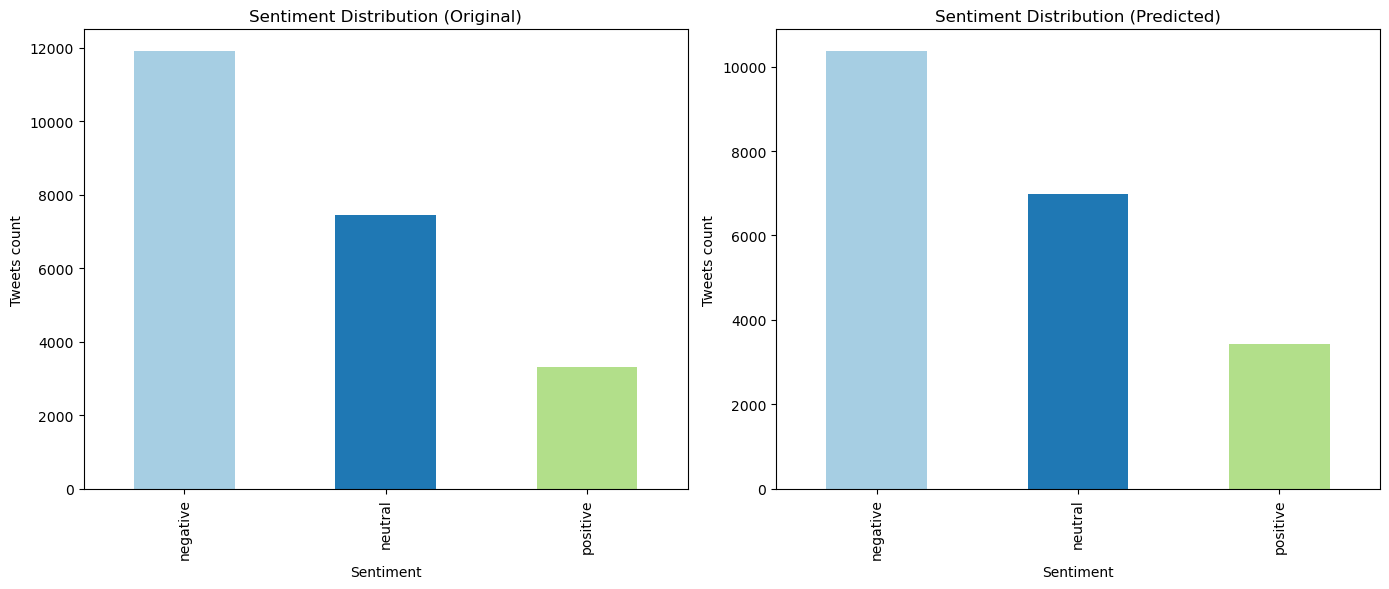

In [4]:
# Analysis on most frequent bigrams: 
tweets = df['Tweets'].tolist()
vectorizer=CountVectorizer(ngram_range=(2,2),stop_words='english')
matrix=vectorizer.fit_transform(tweets)

# Sum the counts of each bigram
bigram_counts = matrix.sum(axis=0).A1
bigram_vocab = vectorizer.get_feature_names_out()

# Combine into a DataFrame for easy viewing
bigram_df = pd.DataFrame({'bigram': bigram_vocab, 'count': bigram_counts})
bigram_df = bigram_df.sort_values(by='count', ascending=False)

print(bigram_df.head(10))

# Create a figure with two subplots of labels
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
sentiment_order = ['negative', 'neutral', 'positive'] # Explicitly define categories order to make it consistent between plots 

df['Sentiment'].value_counts().reindex(sentiment_order).plot(kind='bar', ax=axes[0], title='Sentiment Distribution (Original)', color=plt.cm.Paired(range(len(sentiment_order))))
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Tweets count')


df_annotated = pd.read_csv('Labeled tweets final.csv')
label_map = {2: 'positive', 1: 'neutral', 0: 'negative'}
df_annotated['predicted_label'] = df_annotated['predicted_label'].map(label_map)

df_annotated['predicted_label'].value_counts().reindex(sentiment_order).plot(kind='bar', ax=axes[1], title='Sentiment Distribution (Predicted)', color=plt.cm.Paired(range(len(sentiment_order))))
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Tweets count')

plt.tight_layout()
plt.show()
